```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { btn.click(); }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
    } 
    
setInterval(ClickConnect,1000*60);

```

```python
# 코랩 한글 설치 
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
```

```python
# 한글 테스트 
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()
```

In [1]:
import os
import sys
import joblib
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np

from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_info_columns', 500)

import datetime
from tqdm import tqdm

In [2]:
# visualize
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# Data Load
* embedding ver4 (90 dim)

In [4]:
cd /content/drive/My Drive/쇼핑광고등어

/content/drive/My Drive/쇼핑광고등어


In [5]:
data_v4 = joblib.load(os.path.join('1. Data', '05_분석데이터', '5th_FE_ver4.pkl'))
locals().update(data_v4)

In [6]:
X = data_v4['X'] ; y = data_v4['y']
X.shape, y.shape

((35379, 334), (35379,))

In [7]:
X = X.drop(["log최근3개월상품군추세"], axis=1)

### target distribution

In [8]:
# log(y)
y2 = np.log1p(y)

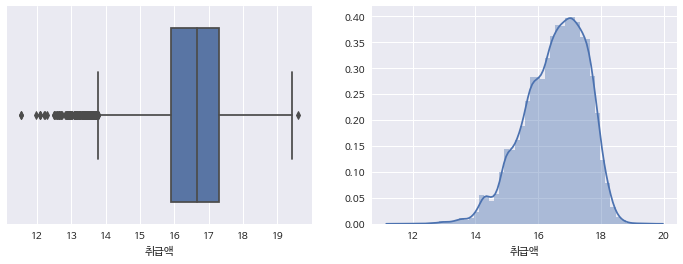

In [9]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(y2, ax=ax1)
sns.distplot(y2, ax=ax2)

# Modeling 
* cv = 5, epoch = 5000, early = 500, random_state=77

In [10]:
import random

import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score

In [11]:
# mape
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
# mape with exp
def MAPE_exp(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))) * 100

In [13]:
def mape_cv(model, X, y, n_folds):
  kf = KFold(n_folds, shuffle=True, random_state=77).get_n_splits(X.values)
  mape = cross_val_score(model, X.values, y, scoring = make_scorer(MAPE_exp), cv=kf)
  return mape

In [14]:
# MAPE_exp_cv 구현
def MAPE_exp_cv(model,X,y,cv_splits):        
    mape = []

    # for 문 돌리기
    cv = KFold(n_splits=cv_splits, random_state=77, shuffle=True)
    for t,v in cv.split(X):
        X_train=X.iloc[t]       # 훈련용
        X_val=X.iloc[v]         # 검증용 분리
        y_train=y.iloc[t]
        y_val=y.iloc[v]

        # model
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)

        # mape
        mape.append(MAPE_exp(y_val, y_pred))

    return mape, np.mean(mape)

## sklearn wrapper 사용해서 그냥 뽑아보기! 
* eval set을 설정해 줘야 하므로 python wrapper로 직접 짜는게 맞는 것 같긴 하다..

### lgbm

In [11]:
from lightgbm import LGBMRegressor

In [15]:
# eval set 없음 
lgbm = LGBMRegressor(learning_rate=0.03, n_estimators=1000, verbose=1, 
                     min_child_samples=40, num_leaves=16, max_depth=8, subsample=0.8)
MAPE_exp_cv(lgbm, X, y2, 5) 

([37.432006553949236,
  39.90506605224588,
  38.19402359218019,
  37.69686970301002,
  37.89375820693795],
 38.22434482166465)

In [16]:
# 파라미터 설정해 줘도 값이 다르네용.. 
mape_cv(lgbm, X, y2, 5)

array([58.93277647, 47.48674251, 46.33291454, 52.72551332, 75.60468247])

### xgboost

In [17]:
from xgboost import XGBRegressor

In [21]:
xgb_params = {
            'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 
            'objective': 'reg:linear', 
            'num_boost_around' : 1000, 
            'lambda': 0.00001 , 
            'alpha': 0.4,
            'max_depth': 16,
            'eta': 0.03,
            'gamma': 0.000005,
            'grow_policy': 'depthwise',
            'subsample': 0.9,
            'colsample_bytree': 0.6,
            'colsample_bylevel': 0.6,
            'min_child_weight': 9,
            'max_bin': 70,        
            }

In [22]:
xgb = XGBRegressor(params = xgb_params)

In [23]:
MAPE_exp_cv(xgb, X, y2, 5) 

[02:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


([56.16069133646565,
  57.80197666326827,
  57.45816023419499,
  56.69314738385748,
  57.67289699418628],
 57.157374522394534)

In [24]:
mape_cv(xgb, X, y2, 5)

[02:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([70.81935328, 59.86165742, 57.3527693 , 63.58286711, 78.61200312])

## python wrapper 사용하기 

### LGBM
* gpu on Colab : https://somjang.tistory.com/entry/Ensemble-Colab%EC%97%90%EC%84%9C-LightGBM-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0
* parameter tuning : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

#### lgbm_params1

In [24]:
lgb_params1 = {'learning_rate': 0.02, 'max_depth' : 24, 'objective': 'regression', 'metric': 'mape', 'is_training_metric': True, 
              'lambda_l1': 0.7, 'min_child_samples' : 35, 'n_estimators' : 10000, 'num_leaves' : 30, 'bagging_fraction': 0.8}

In [21]:
def lgbm_model(X, y, params, n) : 

    mape = {'val_mape' : [], 'test_mape' : []}
    pred = {'val_pred' : [], 'test_idx' : [], 'test_pred' : []}    
    lgbm_feat_imp = [0] * len(X.columns)


    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=77)
    pred['test_idx'].append(X_test_.index)


    cv = KFold(n_splits=n, random_state=77, shuffle=True)
    for t,v in cv.split(X_train_):
        X_train , X_val = X_train_.iloc[t] , X_train_.iloc[v]            
        y_train , y_val = y_train_.iloc[t] , y_train_.iloc[v]


        train_T = lgb.Dataset(X_train.values, label=y_train.values) 
        val_T   = lgb.Dataset(X_val.values, label=y_val.values)       
            

        model = lgb.train(params, train_T, 10000, valid_sets = val_T, verbose_eval=2500, early_stopping_rounds=500)
        

        # val
        val_pred = model.predict(X_val.values)
        pred['val_pred'].append(np.exp(val_pred))              
        mape['val_mape'].append(MAPE_exp(y_val, val_pred))


        # test 
        test_pred = model.predict(X_test_.values)
        pred['test_pred'].append(np.exp(test_pred))
        mape['test_mape'].append(MAPE_exp(y_test_, test_pred))


        lgbm_feat_imp += model.feature_importance() / n
                    
    
    return mape, pred, lgbm_feat_imp

In [25]:
lgbm_mape1, lgbm_pred1, lgbm_feat_imp1 = lgbm_model(X, y2, lgb_params1, 5)

Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0186174
[5000]	valid_0's mape: 0.0183061
Early stopping, best iteration is:
[5504]	valid_0's mape: 0.0182933
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0184831
[5000]	valid_0's mape: 0.0180492
Early stopping, best iteration is:
[5424]	valid_0's mape: 0.0180297
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0189294
[5000]	valid_0's mape: 0.0185587
Early stopping, best iteration is:
[6974]	valid_0's mape: 0.0185193
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0185462
[5000]	valid_0's mape: 0.0181903
Early stopping, best iteration is:
[6022]	valid_0's mape: 0.0181662
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0187734
[5000]	valid_0's mape: 0.0184153
Early stopping, best iteration is:
[5590]	valid_0's mape: 0.0184025


In [26]:
pd.DataFrame(lgbm_mape1)

,val_mape,test_mape
0,33.371651,32.826884
1,32.745022,32.989158
2,34.459030,33.344431
3,32.101839,32.872548
4,33.882011,32.393097


In [53]:
print(np.mean(lgbm_mape1['val_mape']), np.mean(lgbm_mape1['test_mape']))

33.31191085328141 32.88522357062282


In [27]:
lgbm_pred1

{'test_idx': [Int64Index([ 8734,  7885,  2413, 12475,  4571,  9835, 35907, 14833, 10316,
              31140,
              ...
              25556, 30587,  6430, 11575, 33365, 14158, 28909, 34363, 26499,
               4615],
             dtype='int64', length=7076)],
 'test_pred': [array([ 9559731.24623712, 15535409.51931835, 22774502.38793227, ...,
         34842087.53385986, 14248276.42673718, 11336119.95776323]),
  array([10666878.03876016, 14846339.13473769, 21503207.07267693, ...,
         37958369.07200798, 11832598.51678996, 11748347.95881028]),
  array([10595816.77034981, 19085536.58125341, 21049871.24803424, ...,
         33033538.84669212, 11290666.01127749, 11420201.26149556]),
  array([ 8614217.70415896, 15242070.17782404, 25021331.16651201, ...,
         36099044.22175654, 11288637.87720735, 10895310.75136767]),
  array([11513318.39200026, 15331105.34391522, 23548982.06929348, ...,
         34704449.28288619,  7191338.35547145, 12276504.80360022])],
 'val_pred': [array([

* val_idx, val_pred : train set에서 CV 해서 나온 validation set 
* test_idx, test_pred : CV 모델 각각에서 예측한 test set          
  -> 나중에 평균을 취해서 사용하면 될 것 같음 

In [15]:
def lgbm_feature_importance(importance_result) : 
    feature_importance = pd.DataFrame({'feature' : X.columns, 'importance' : importance_result}).sort_values(by='importance', ascending=False)

    fig, ax = plt.subplots(figsize=(12,30))

    sns.barplot(
        data= feature_importance[feature_importance["importance"] > 20],
        x= "importance",
        y= "feature"
    )   

    plt.show()

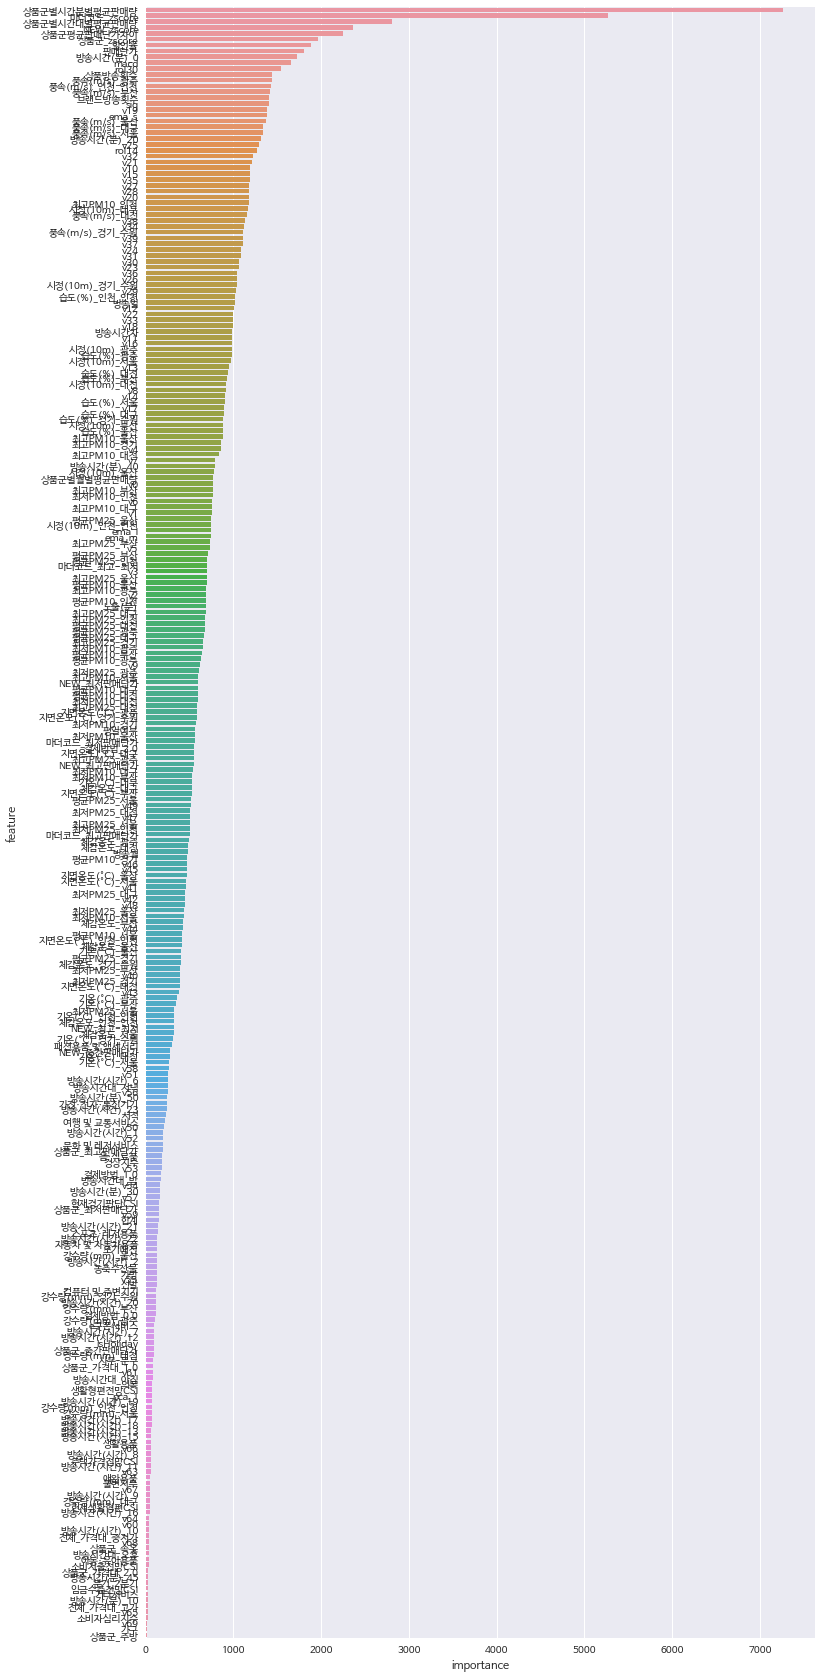

In [57]:
lgbm_feature_importance(lgbm_feat_imp1)

#### lgbm_params2
* Optuna : Hyperparameter Tuning

In [17]:
# !pip install optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [31]:
def objective_lgbm(trial, X, y):
    
    params = {
        'num_leaves': int(trial.suggest_loguniform('num_leaves', 2, 2**7)),  
        'max_depth': trial.suggest_int('max_depth', 8, 100), # -1
        'min_child_samples': trial.suggest_int('min_child_samples', 8, 64),  
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 50.0),  
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.05),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0), 
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0), 
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0), 
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 10000, 30000),
        'boost_from_average': trial.suggest_categorical('boost_from_average', [True, False]),  # True
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7), 
        'max_bin': trial.suggest_int('max_bin', 63, 255),  
        'seed': 77,
        'n_jobs': -1,
        'objective': 'regression',
        'num_iterations': 10000,
        'metric': 'mape',
        'importance_type': 'gain'
    }
    
    mape, pred, lgbm_feat_imp = lgbm_model(X, y, params, 5)

    return np.mean(mape['test_mape'])

In [32]:
lgbm_study = optuna.create_study()
lgbm_study.optimize(lambda x: objective_lgbm(x, X, y2), timeout=1000, n_jobs=-1)
print(lgbm_study.best_params, lgbm_study.best_value)

Training until validation scores don't improve for 500 rounds.
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0222518
[2500]	valid_0's mape: 0.0189936
Early stopping, best iteration is:
[3486]	valid_0's mape: 0.0187051
Training until validation scores don't improve for 500 rounds.
[5000]	valid_0's mape: 0.0208475
[7500]	valid_0's mape: 0.0202281
[2500]	valid_0's mape: 0.0188324
Early stopping, best iteration is:
[3587]	valid_0's mape: 0.0184276
[10000]	valid_0's mape: 0.0199495
Did not meet early stopping. Best iteration is:
[9988]	valid_0's mape: 0.0199471
Training until validation scores don't improve for 500 rounds.
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0222152
[2500]	valid_0's mape: 0.019343
Early stopping, best iteration is:
[3387]	valid_0's mape: 0.0190301
Training until validation scores don't improve for 500 rounds.
[5000]	valid_0's mape: 0.0206035
[7500]	valid_0's mape: 0.0198753
[2500]	

In [49]:
# lgbm_params2 = lgbm_study.best_params

lgbm_params2 = {
    'boost_from_average': False,
    'learning_rate': 0.025,
    'max_depth': 38,
    'min_child_samples': 45,
    'min_child_weight': 0.05,
    'min_split_gain': 0.035,
    'num_leaves': 12,
    'reg_alpha': 0.02,
    'reg_lambda': 0.7,
    'subsample': 0.87, 

    'objective': 'regression', 
    'metric': 'mape', 
    'is_training_metric': True, 
    'n_estimators' : 10000
}

In [50]:
lgbm_mape2, lgbm_pred2, lgbm_feat_imp2 = lgbm_model(X, y2, lgbm_params2, 5)

Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.019708
[5000]	valid_0's mape: 0.018733
Early stopping, best iteration is:
[5786]	valid_0's mape: 0.0186095
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.019714
[5000]	valid_0's mape: 0.0186531
Early stopping, best iteration is:
[6049]	valid_0's mape: 0.0184901
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0202496
[5000]	valid_0's mape: 0.0192517
Early stopping, best iteration is:
[5789]	valid_0's mape: 0.0191291
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0198139
[5000]	valid_0's mape: 0.0187252
Early stopping, best iteration is:
[5982]	valid_0's mape: 0.0185437
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0198113
[5000]	valid_0's mape: 0.0189451
Early stopping, best iteration is:
[6006]	valid_0's mape: 0.0188272


In [51]:
pd.DataFrame(lgbm_mape2)

,val_mape,test_mape
0,34.104347,33.813358
1,33.868598,34.149055
2,36.017387,34.248423
3,33.064648,33.873827
4,34.659505,33.307198


In [52]:
print(np.mean(lgbm_mape2['val_mape']), np.mean(lgbm_mape2['test_mape']))

34.342897267704316 33.87837221575906


#### lgbm_params3
* Optuna : Hyperparameter Tuning
* 공식문서 참고해서 재조정 
* L1 Regularization 

In [60]:
def objective_lgbm(trial, X, y):
    
    params = {
        'num_leaves': int(trial.suggest_loguniform('num_leaves', 16, 256)),  
        'max_depth': trial.suggest_int('max_depth', 8, 16), # -1
        'min_child_samples': trial.suggest_int('min_child_samples', 32, 128),  
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.03),
        'lambda_l1': trial.suggest_uniform('reg_alpha', 0.5, 1.0),  # L1
#        'lambda_l2': trial.suggest_uniform('reg_lambda', 0.0, 1.0), # L2
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),  
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7), 
        'max_bin': trial.suggest_int('max_bin', 15, 63),  
        'seed': 77,
        'n_jobs': -1,
        'objective': 'regression',
        'num_iterations': 50000,
        'metric': 'mape',
        'is_training_metric': True, 
        'importance_type': 'gain',
        'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
    }
    
    mape, pred, lgbm_feat_imp = lgbm_model(X, y, params, 5)

    return np.mean(mape['test_mape'])

In [61]:
lgbm_study2 = optuna.create_study()
lgbm_study2.optimize(lambda x: objective_lgbm(x, X, y2), timeout=1000, n_jobs=-1)
print(lgbm_study2.best_params, lgbm_study2.best_value)

Training until validation scores don't improve for 500 rounds.
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0187832
[2500]	valid_0's mape: 0.0186395
Early stopping, best iteration is:
[4042]	valid_0's mape: 0.0186148
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[4314]	valid_0's mape: 0.0184418
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0184258
[5000]	valid_0's mape: 0.0181864
Early stopping, best iteration is:
[4649]	valid_0's mape: 0.0181706
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0185381
[2500]	valid_0's mape: 0.0189852
[5000]	valid_0's mape: 0.0181778
Early stopping, best iteration is:
[4860]	valid_0's mape: 0.0181723
Training until validation scores don't improve for 500 rounds.
[5000]	valid_0's mape: 0.0187635
Early stopping, best iteration is:
[4824]	valid_0's mape: 0.0187551
Training until val

In [62]:
lgbm_params3 = lgbm_study2.best_params.copy()
lgbm_params3['num_leaves'] = int(lgbm_params3['num_leaves'])
lgbm_params3['n_jobs'] = -1
lgbm_params3['num_iterations'] = 10000
lgbm_params3['objective'] = 'regression'
lgbm_params3['metric'] = 'mape'
lgbm_params3['is_training_metric'] = True

In [63]:
lgbm_mape3, lgbm_pred3, lgbm_feat_imp3 = lgbm_model(X, y2, lgbm_params3, 5)

Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0188089
Early stopping, best iteration is:
[3912]	valid_0's mape: 0.0186287
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.018453
[5000]	valid_0's mape: 0.0182141
Early stopping, best iteration is:
[4522]	valid_0's mape: 0.0181969
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0190149
[5000]	valid_0's mape: 0.0188061
Early stopping, best iteration is:
[5043]	valid_0's mape: 0.0187982
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0187815
[5000]	valid_0's mape: 0.018532
Early stopping, best iteration is:
[5365]	valid_0's mape: 0.0185191
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0189958
Early stopping, best iteration is:
[4173]	valid_0's mape: 0.0188359


In [64]:
pd.DataFrame(lgbm_mape3)

,val_mape,test_mape
0,34.049010,33.653246
1,33.065774,33.637131
2,35.085109,33.800091
3,32.924782,33.317124
4,34.685973,33.045729


In [65]:
print(np.mean(lgbm_mape3['val_mape']), np.mean(lgbm_mape3['test_mape']))

33.96212951420776 33.490664103393684


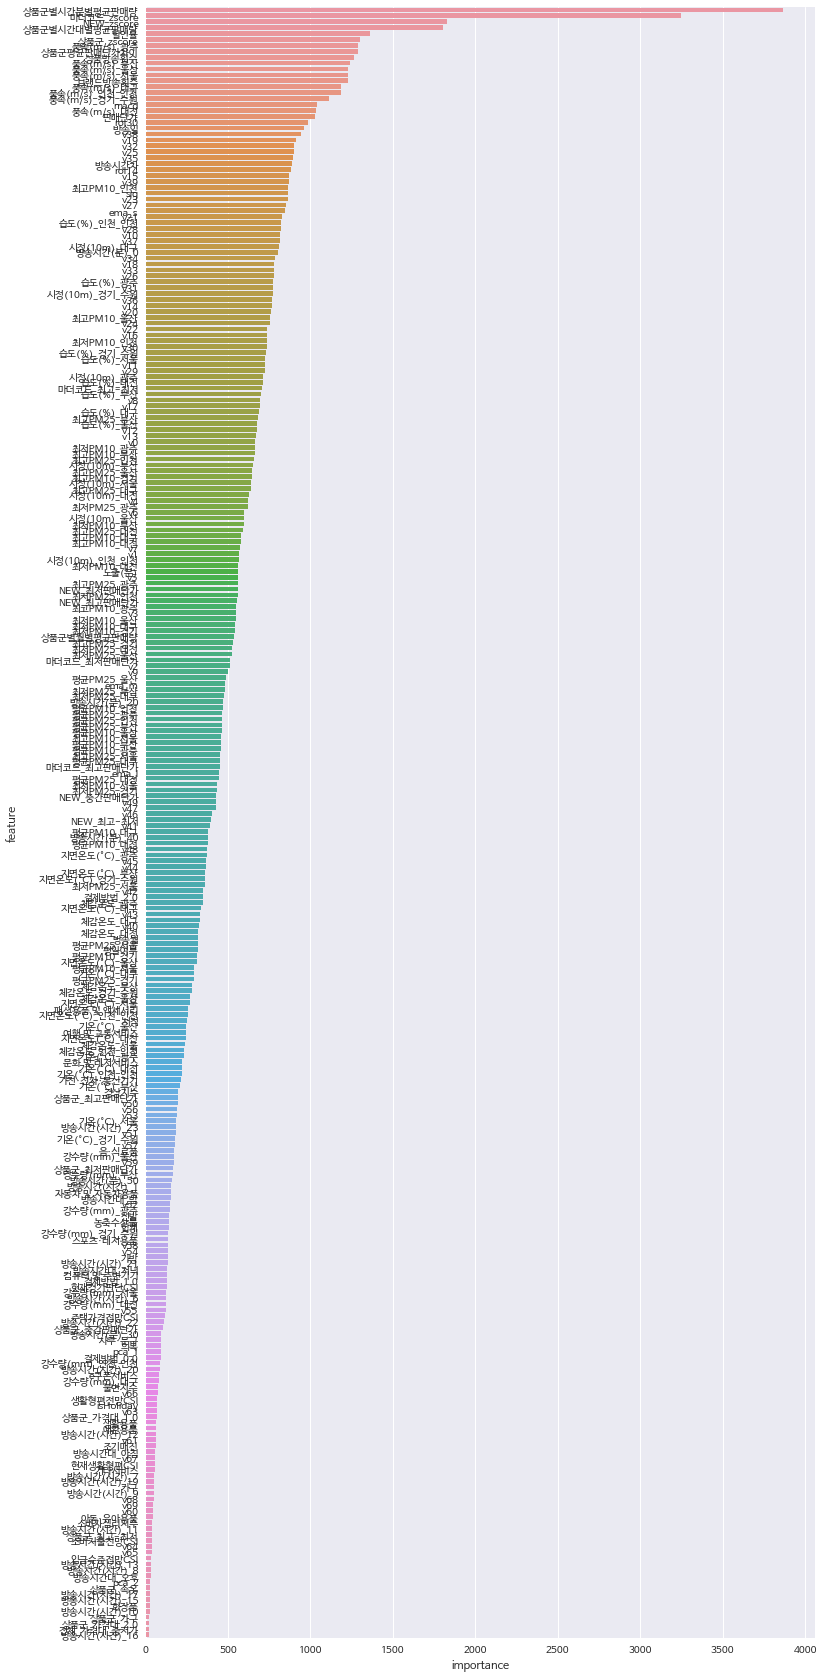

In [66]:
lgbm_feature_importance(lgbm_feat_imp3)

#### lgbm_parmas4
* feature 중요도 시각화 : SHAP (https://github.com/slundberg/shap)
* L2 Regularization
* overfitting 발생하는 쪽으로 최적화를 하넹...ㅎ 이게먼일...

In [ ]:
# !pip install shap

In [30]:
import shap

In [19]:
def objective_lgbm(trial, X, y):
    
    params = {
        'num_leaves': int(trial.suggest_loguniform('num_leaves', 16, 256)),  
        'max_depth': trial.suggest_int('max_depth', 8, 16), # -1
        'min_child_samples': trial.suggest_int('min_child_samples', 32, 128),  
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.03),
#        'lambda_l1': trial.suggest_uniform('reg_alpha', 0.5, 1.0),  # L1
        'lambda_l2': trial.suggest_uniform('reg_lambda', 0.0, 1.0), # L2
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),  
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 15), 
        'max_bin': trial.suggest_int('max_bin', 15, 63),  
        'seed': 77,
        'n_jobs': -1,
        'objective': 'regression',
        'num_iterations': 10000,
        'metric': 'mape',
        'is_training_metric': True, 
        'importance_type': 'gain',
        'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
    }
    
    mape, pred, lgbm_feat_imp = lgbm_model(X, y, params, 5)

    return np.mean(mape['test_mape'])

In [22]:
lgbm_study3 = optuna.create_study()
lgbm_study3.optimize(lambda x: objective_lgbm(x, X, y2), timeout=1000, n_jobs=-1)
print(lgbm_study3.best_params, lgbm_study3.best_value)

Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0185293
Early stopping, best iteration is:
[2910]	valid_0's mape: 0.0185006
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0183821
[2500]	valid_0's mape: 0.0342925
Early stopping, best iteration is:
[3102]	valid_0's mape: 0.0183476
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0189006
Early stopping, best iteration is:
[2849]	valid_0's mape: 0.0188772
Training until validation scores don't improve for 500 rounds.
[2500]	valid_0's mape: 0.0185137
Early stopping, best iteration is:
[3073]	valid_0's mape: 0.0184854
Training until validation scores don't improve for 500 rounds.
[5000]	valid_0's mape: 0.0219147
[2500]	valid_0's mape: 0.0185528
Early stopping, best iteration is:
[2679]	valid_0's mape: 0.0185448
[7500]	valid_0's mape: 0.020248
[10000]	valid_0's mape: 0.0189789
[2500]	valid_0's mape: 0.0341258
[5000]	valid_0'

In [26]:
lgbm_params4 = lgbm_study3.best_params.copy()
lgbm_params4['num_leaves'] = int(lgbm_params4['num_leaves'])
lgbm_params4['n_jobs'] = -1
lgbm_params4['num_iterations'] = 10000
lgbm_params4['objective'] = 'regression'
lgbm_params4['metric'] = 'mape'
lgbm_params4['is_training_metric'] = True

In [27]:
def lgbm_model_SHAP(X, y, params, n) : 

    mape = {'val_mape' : [], 'test_mape' : []}
    pred = {'val_pred' : [], 'test_idx' : [], 'test_pred' : []}    
    lgbm_feat_imp = [0] * len(X.columns)


    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=77)
    pred['test_idx'].append(X_test_.index)


    SHAP_values = []


    cv = KFold(n_splits=n, random_state=77, shuffle=True)
    for t,v in cv.split(X_train_):
        X_train , X_val = X_train_.iloc[t] , X_train_.iloc[v]            
        y_train , y_val = y_train_.iloc[t] , y_train_.iloc[v]


        train_T = lgb.Dataset(X_train.values, label=y_train.values) 
        val_T   = lgb.Dataset(X_val.values, label=y_val.values)       
            

        model = lgb.train(params, train_T, 10000, valid_sets = val_T, verbose_eval=2500, early_stopping_rounds=500)
        

        # val
        val_pred = model.predict(X_val.values)
        pred['val_pred'].append(np.exp(val_pred))              
        mape['val_mape'].append(MAPE_exp(y_val, val_pred))


        # test 
        test_pred = model.predict(X_test_.values)
        pred['test_pred'].append(np.exp(test_pred))
        mape['test_mape'].append(MAPE_exp(y_test_, test_pred))


        lgbm_feat_imp += model.feature_importance() / n


        # SHAP 
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_.values)
        SHAP_values.append(shap_values)
                    
    
    return mape, pred, lgbm_feat_imp, SHAP_values

In [31]:
lgbm_mape4, lgbm_pred4, lgbm_feat_imp4, lgbm_SHAP4 = lgbm_model_SHAP(X, y2, lgbm_params4, 5)

[2500]	valid_0's mape: 0.0325701
[5000]	valid_0's mape: 0.0217346
[7500]	valid_0's mape: 0.0197519
[10000]	valid_0's mape: 0.0190954
[2500]	valid_0's mape: 0.0323853
[5000]	valid_0's mape: 0.0214616
[7500]	valid_0's mape: 0.0194991
[10000]	valid_0's mape: 0.0188672
[2500]	valid_0's mape: 0.0326675
[5000]	valid_0's mape: 0.0220884
[7500]	valid_0's mape: 0.0201621
[10000]	valid_0's mape: 0.019565
[2500]	valid_0's mape: 0.0328942
[5000]	valid_0's mape: 0.0220611
[7500]	valid_0's mape: 0.0200584
[10000]	valid_0's mape: 0.0194335
[2500]	valid_0's mape: 0.0328157
[5000]	valid_0's mape: 0.0219455
[7500]	valid_0's mape: 0.0200251
[10000]	valid_0's mape: 0.0194739


In [32]:
pd.DataFrame(lgbm_mape4)

,val_mape,test_mape
0,31.523107,31.465114
1,30.982393,31.359423
2,32.818250,31.711096
3,31.255390,31.484270
4,32.060775,31.019635


In [34]:
print(np.mean(lgbm_mape4['val_mape']), np.mean(lgbm_mape4['test_mape']))

31.727982914002006 31.407907700168245


In [35]:
final = {
    'lgbm_4th' : [lgbm_mape4, lgbm_pred4, lgbm_feat_imp4, lgbm_SHAP4]
}

In [37]:
import pickle as pkl
with open("0912_pred.pkl", 'wb') as f:
    pkl.dump(final,f)

In [100]:
import shap

In [101]:
shap.initjs()

In [70]:
# SHAP value 
a = np.sum(lgbm_SHAP4, axis=0)
a

array([[ 1.87037271e-02, -1.04374575e-01, -1.32486317e-02, ...,
         6.56929278e-06, -3.84979514e-06, -5.92085302e-06],
       [ 1.72533748e-02, -5.22884366e-02, -1.24634851e-02, ...,
        -4.10309550e-05,  1.30214832e-04, -1.83855285e-05],
       [ 2.15016270e-02,  1.17195895e-01,  6.81954081e-04, ...,
        -6.45871594e-06,  5.50236673e-05,  3.10407755e-06],
       ...,
       [ 4.03000954e-02,  6.85069940e-02, -1.23472402e-02, ...,
        -1.14257968e-05,  2.89699231e-05,  2.89217282e-06],
       [ 1.74014258e-02, -3.00203129e-02, -7.07809997e-03, ...,
         1.94393783e-05,  9.16175410e-06,  2.93118480e-06],
       [ 2.32761505e-02, -2.01601511e-03, -6.38894792e-02, ...,
        -1.74617639e-07, -7.41319486e-05,  2.79077591e-06]])

In [93]:
test = X.loc[lgbm_pred4['test_idx'][0]]

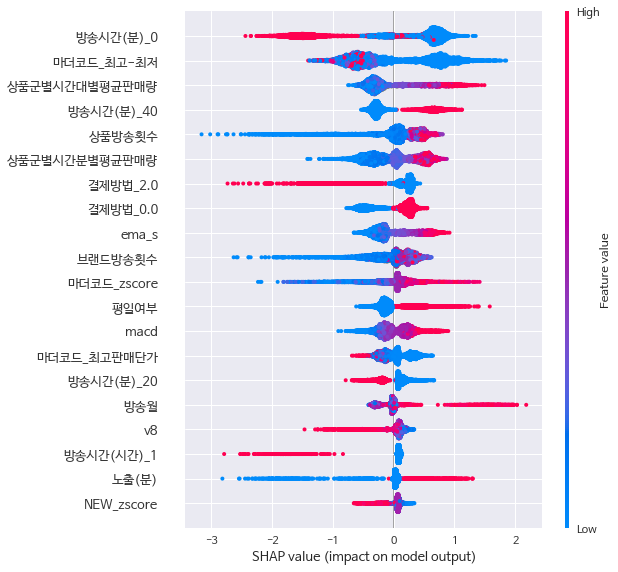

In [103]:
shap.summary_plot(a, test)

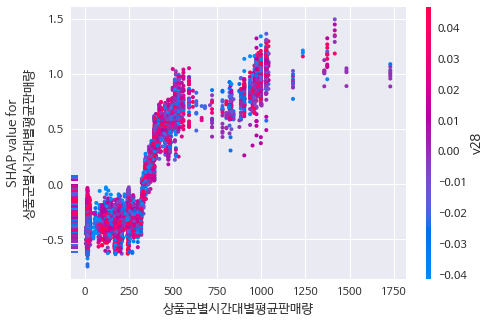

In [108]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("상품군별시간대별평균판매량", a, test)

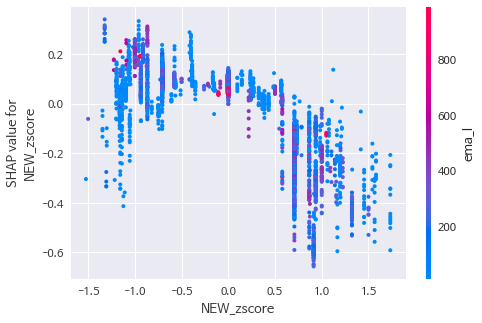

In [109]:
shap.dependence_plot("NEW_zscore", a, test)

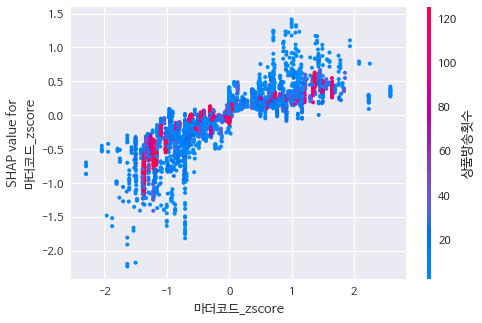

In [105]:
shap.dependence_plot("마더코드_zscore", a, test)

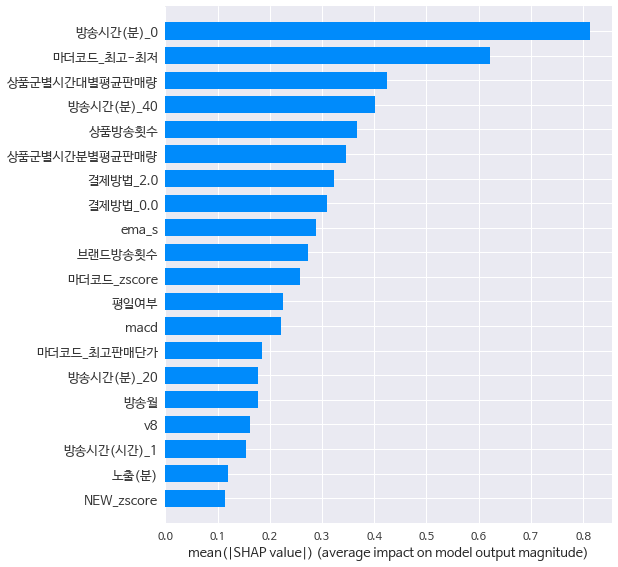

In [106]:
shap.summary_plot(a, test, plot_type="bar")

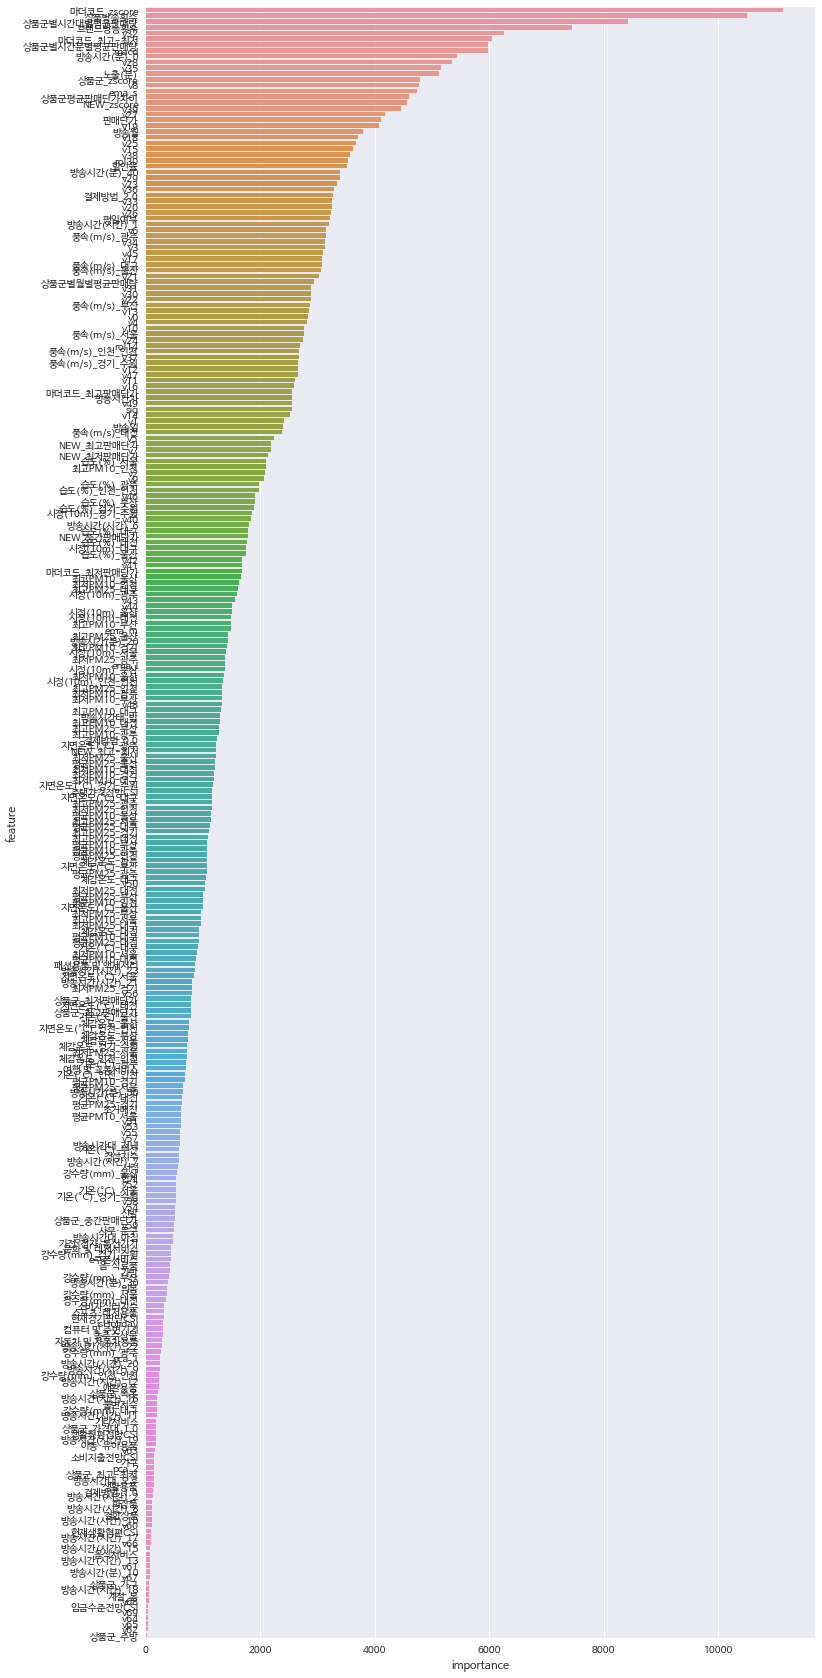

In [107]:
lgbm_feature_importance(lgbm_feat_imp4)

#### lgbm_params5